### Import packages

In [144]:
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob 
import os
import json
from matplotlib.colors import LogNorm

In [145]:
#root_folder_path = "N:\\durable\\sound-and-ecg\\2024-10-Maja-restructured\\Data"
root_folder_path = "C:\\Users\\MajaE\\src\\repos\\master_ML\\Data"

### Extract data

In [146]:
def extract_test_parameters(test_file):
    true,predictions,predictions_proba,test_recording_ids,segment_parameters =[],[],[],[],[]
    with open(test_file, 'rb') as handle:
        true,predictions,predictions_proba,test_recording_ids, segment_parameters = pickle.load(handle) 
    return true,predictions,predictions_proba,test_recording_ids,segment_parameters

### Analyze metrics

In [147]:
def calculate_metrics(true,predictions):
    accuracy = accuracy_score(true, predictions) # ((TN + TP) / (TN + FN + TP + FP))
    precision = precision_score(true, predictions,zero_division=np.nan) # Positive predictive rate -> TP/(TP+FP)
    recall = recall_score(true, predictions,zero_division=np.nan) # Sensitivity -> TP/(TP+FN)
    f1 = f1_score(true,predictions,zero_division=np.nan)
    specificity = 0
    return accuracy,recall,specificity,precision,f1

### Plot ROC curve

In [148]:
def find_avg_performance(folder_path):
    test_files = glob.glob(os.path.join(folder_path,'*.pickle'))
    true, predictions, predictions_proba, ids, segment_parameters = [], [], [], [], []
    for test_file in test_files:
        true_subject, predictions_subject,predictions_proba_subject,test_recording_ids,segment_parameters_subject = extract_test_parameters(test_file)
        true.extend(true_subject)
        predictions.extend(predictions_subject)
        predictions_proba.extend(predictions_proba_subject)
        ids.extend(test_recording_ids)
        segment_parameters.extend([segment_parameters_subject])
    accuracy_vector, specificity_vector, recall_vector, precision_vector, f1_vector = [], [], [], [], []
    for subject_idx in range(len(true)):
        accuracy,specificity,recall,precision,f1 = calculate_metrics(true[subject_idx],predictions[subject_idx])
        accuracy_vector.append(accuracy)
        specificity_vector.append(specificity)
        recall_vector.append(recall)
        precision_vector.append(precision)
        f1_vector.append(f1)
    accuracy = np.mean(accuracy_vector)
    specificity = np.mean(specificity_vector)
    recall = np.mean(recall_vector)
    precision = np.mean(precision_vector)
    f1 = np.mean(f1_vector)
    return accuracy, f1

In [149]:
def feature_selection_performance(root_folder_path):
    accuracy = []
    f1 = []
    run_folder_path = root_folder_path
    for run in os.listdir(root_folder_path):
        run_accuracy = []
        run_f1 = []
        run_folder_path = os.path.join(root_folder_path,run)
        data_folder_path = os.path.join(run_folder_path,"data")
        for iteration in os.listdir(data_folder_path):
            iteration_path = os.path.join(data_folder_path,iteration)
            i_accuracy, i_f1 = find_avg_performance(iteration_path)
            run_accuracy.append(i_accuracy)
            run_f1.append(i_f1)
        accuracy.append(run_accuracy)
        f1.append(run_f1)
    
    avg_accuracy = []
    avg_f1 = []
    n_runs = len(accuracy)
    n_features = len(accuracy[0])
    for i in range (n_features):
        acc_sum = 0
        f1_sum = 0
        for j in range (n_runs):
            acc_sum += accuracy[j][i]
            f1_sum += f1[j][i]
        avg_accuracy.append(acc_sum/n_runs)
        avg_f1.append(f1_sum/n_runs)

    parameters_path = f"{run_folder_path}\\parameters.json"
    test_values = []
    with open(parameters_path, 'r') as file:
        meta_data = json.load(file)
        test_values = meta_data["test_values"]
    
    return avg_accuracy, avg_f1, test_values


In [150]:
def feature_selection_curve(selection_algorithms,label):
    accuracies, f1_scores, n_features_vec = [], [], []
    for selection_algorithm in selection_algorithms:
        accuracy, f1, n_features = feature_selection_performance(selection_algorithm)
        accuracies.append(accuracy)
        f1_scores.append(f1)
        n_features_vec.append(n_features) 

    plt.figure()
    for idx in range (len(accuracies)):
        plt.plot(n_features_vec[idx],accuracies[idx],label=selection_algorithms[idx])
    plt.xlabel('Number of selected features')
    plt.ylabel('Accuracy')
    plt.title(f'Performance of {label}')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    for idx in range (len(f1_scores)):
        plt.plot(n_features_vec[idx],f1_scores[idx],label=selection_algorithms[idx])
    plt.xlabel('Number of selected features')
    plt.ylabel('F1')
    plt.title(f'Performance of {label}')
    plt.legend()
    plt.grid(True)
    plt.show()

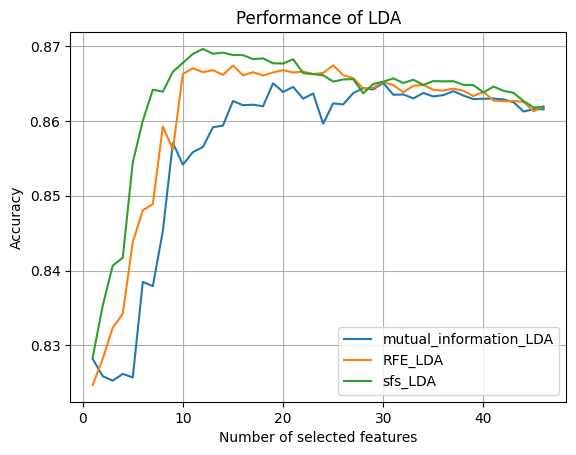

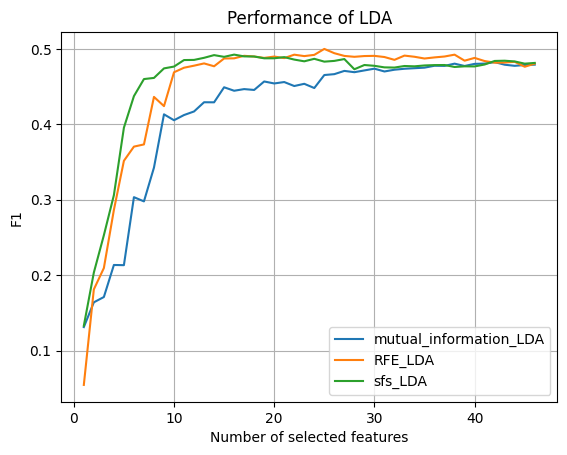

In [151]:
classes = ['No meal','Meal']
selection_algorithms = ["mutual_information_LDA","RFE_LDA","sfs_LDA"]
#selection_algorithms = ["mutual_information_HMM","RFE_HMM"]
feature_selection_curve(selection_algorithms,'LDA')

In [157]:

importance_mutual_information, importance_RFE, importance_sfs = [],[],[]
# Extract features from previous calculations
with open(f'..\\feature_selection_LDA.pickle', 'rb') as handle:
    importance_mutual_information, importance_RFE, importance_sfs = pickle.load(handle)
print(importance_mutual_information)
print(importance_RFE)
print(importance_sfs)

[ 4  1  3  2 20  6  7 28  5 24 10 27 13 19 29 31 38 43 35  9 14  8 39 22
 37 11 33 15 25 18 45 23 42 32 34 30 44 26 46 16 36 17 41 12 40 21]
[ 5 41 12  1 42  2 46  9  3 27  4  7  6 13 14 29 16 26 15 10 45 17 19 18
 30 20 32 31  8 40 43 44 21 22 39 38 36 35 23 24 11 33 28 34 25 37]
[ 7  1 44  4 20  6 16 28 12 45  3 21 46 10 11 43 42 18 13  9  2 31 17 19
 15 30 22 34  5 36 37 38 40 39 33 23 29 27 24 32 14 35  8 25 41 26]
